# 6. Custom Model Approach

## 6.1 Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder,Normalizer,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import TruncatedSVD, PCA 
from sklearn.linear_model import LassoLarsCV,Ridge
from mlxtend.regressor import StackingCVRegressor 
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

## 6.2 Data Loading and Preprocessing

In [2]:
train = pd.read_csv('train.csv')
print(f"total train datapoints = {len(train)}") 
test = pd.read_csv('test.csv')
print(f"total test datapoints = {len(test)}")

total train datapoints = 4209
total test datapoints = 4209


In [3]:
def preprocess_categorical(data, IDs):
    """
    data : pandas dataframe
    IDs: ID feature
    return: dataframe, labels
    
    This function takes the dataframe as input, 
    encodes and normalizes the 
    categorical features.
    """
    # create empty lists for collecting feature names
    cat_features = []
    Binary_features = []
    
    # Collect the categorical and binary feature names 
    for f in data.columns:
        if data[f].dtype == 'object':
            cat_features.append(f)
        elif data[f].dtype == 'int' and f != 'ID':
            Binary_features.append(f)
        
    # create categorical feature dataframe
    cat_df = data[cat_features]
    # create binary feature dataframe
    bin_df = data[Binary_features]
    bin_df.insert(0, 'ID', IDs.values)
    
    # Now encode each categorical feature
    for feature in cat_features:
        encoder = LabelEncoder()
        cat_df[feature] = encoder.fit_transform(cat_df[feature].values)
    # normalize the enocded categorical features
    # normalized = Normalizer().fit_transform(cat_df)
    # Create new categorical feature dataframe
    cat_df = pd.DataFrame(cat_df, columns = cat_features)
    cat_df.insert(0, 'ID', IDs.values)
    # Merge binary and categorical dataframes together
    new_data = pd.merge(cat_df, bin_df, on='ID', how='left')
    # return dataframe and labels
    if 'y' in data.columns:
        labels = data['y']
        return new_data, labels
    else:
        return new_data

In [4]:
drop_feat = ['X4', 'X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 
  'X330', 'X339', 'X347', 'X35', 'X37', 'X39', 'X57', 'X76', 'X84', 'X94', 'X102', 'X113', 'X119', 
 'X120', 'X122', 'X130', 'X134', 'X136', 'X146', 'X147','X157', 'X172', 'X194', 'X199', 'X205', 
 'X213', 'X214', 'X216', 'X222', 'X226', 'X227', 'X232', 'X239', 'X242', 'X243', 'X244', 'X245',
 'X247', 'X248', 'X253', 'X254', 'X262', 'X263', 'X266', 'X279', 'X296', 'X299', 'X302', 'X320', 
 'X324', 'X326', 'X360', 'X364', 'X365', 'X382', 'X385']

In [5]:
clean_train = train[train['y']<155]

final_train = clean_train.drop(drop_feat, axis=1)

final_train = final_train.drop('ID', axis=1)

train_ID = clean_train['ID'].copy()

print(f"Before removing non informative features:{clean_train.shape}")
print(f"After removing non informative features:{final_train.shape}")

Before removing non informative features:(4201, 378)
After removing non informative features:(4201, 310)


In [6]:
final_test = test.drop(drop_feat, axis=1)

final_test = final_test.drop('ID', axis=1)

test_ID = test['ID'].copy()

print(f"Before removing non informative features:{test.shape}")
print(f"After removing non informative features:{final_test.shape}")

Before removing non informative features:(4209, 377)
After removing non informative features:(4209, 309)


## 6.3 Feature Engineering

### 6.3.1 Original

In [7]:
X_train, y_train = preprocess_categorical(final_train, train_ID)

X_train = X_train.drop('ID', axis=1)

X_test = preprocess_categorical(final_test, test_ID)

X_test = X_test.drop('ID', axis=1)

print("Train set:")
print(X_train.shape)
print(y_train.shape)
print("Test set:")
print(X_test.shape)

Train set:
(4201, 309)
(4201,)
Test set:
(4209, 309)


### 6.3.2 PCA

In [8]:
# lets take top 25 pca components
components = 10 
categories = ['X0','X1', 'X2', 'X3', 'X5','X6', 'X8']

pca = PCA(n_components=components, random_state=420)

pca_train = pca.fit_transform(X_train.drop(categories, axis=1))
pca_test = pca.transform(X_test.drop(categories, axis=1))

print(pca_train.shape)
print(pca_test.shape)

(4201, 10)
(4209, 10)


### 6.3.3 SVD

In [9]:
n_comp = 117

categories = ['X0','X1', 'X2', 'X3', 'X5','X6', 'X8']

tsvd = TruncatedSVD(n_components=n_comp, random_state=420)

svd_train = tsvd.fit_transform(X_train.drop(categories, axis=1))
svd_test = tsvd.transform(X_test.drop(categories, axis=1))

print(svd_train.shape)
print(svd_test.shape)

(4201, 117)
(4209, 117)


### 6.3.4 Interaction Features
- Two way interactions X314, X315
- Three way interactions X118,X314,X315

In [10]:
def get_interactions(features):
    """
    features : list of features
    return : interaction between features
    """
    train_inter = 0
    # cv_inter = 0
    test_inter = 0
    for f in range(len(features)):
        train_inter += X_train[features[f]].values
        #cv_inter += X_cv[features[f]].values
        test_inter += X_test[features[f]].values
        
    return train_inter.reshape(-1,1), test_inter.reshape(-1,1)

train_X314_X315, test_X314_X315 = get_interactions(['X314', 'X315'])
train_X118_X314_X315, test_X118_X314_X315 = get_interactions(['X118', 'X314', 
                                                                                 'X315'])

print(train_X314_X315.shape)
print(test_X314_X315.shape)
print(train_X118_X314_X315.shape)
print(test_X118_X314_X315.shape)

(4201, 1)
(4209, 1)
(4201, 1)
(4209, 1)


### 6.3.5 Gaussian Random Projection

In [11]:
# Gaussian Random Projection
n_comp = 10
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_train = grp.fit_transform(X_train)
grp_test = grp.transform(X_test)

print(grp_train.shape)
print(grp_test.shape)

(4201, 10)
(4209, 10)


### 6.3.6 Combine Features

In [12]:
D_train = np.hstack((X_train, pca_train, grp_train, svd_train, train_X314_X315, 
                                     train_X118_X314_X315))


D_test = np.hstack((X_test, pca_test, grp_test, svd_test, test_X314_X315, 
                                    test_X118_X314_X315))

print("Final Dataset Shapes:")
print(D_train.shape)
print(D_test.shape)

Final Dataset Shapes:
(4201, 448)
(4209, 448)


## 6.4 Custom Model

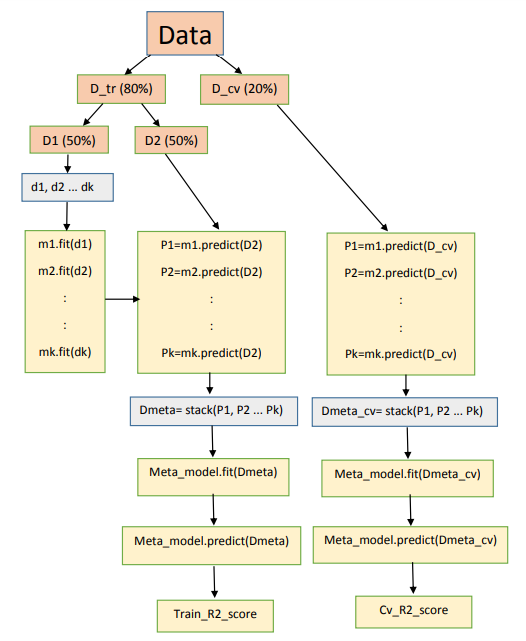

In [13]:
def generate_samples(input_data, target_data):
    '''In this function, we will write code for generating samples '''

    fixed = int(np.ceil(0.6 * len(input_data)))
    changed = int(np.ceil(0.4 * len(input_data))) 
    if (fixed + changed) == len(input_data):
        fixed = fixed
        changed = changed
    elif (fixed + changed) > len(input_data):
        fixed = fixed
        changed = changed - 1
    
    # Getting random row indices from the input_data without replacement
    selecting_rows = np.random.choice(range(len(input_data)), size = fixed , replace=False)
    # Extracting random row indices from the "Selecting_rows" with replacement
    replicating_rows = np.random.choice(selecting_rows, size = changed, replace=True)

    sample_data = input_data[selecting_rows[:]]
    # target of sample data 
    target_of_sample_data = target_data[selecting_rows]
    #Replicating Data
    # Replicated sample data 
    replicated_sample_data = input_data[replicating_rows[:]]
    # target of Replicated sample data target_data[Replaceing rows]
    target_of_replicated_sample_data = target_data[replicating_rows]
    # Concatenating data
    # perform vertical stack on sample data, Replicated sample data
    final_sample_data = np.vstack ((sample_data, replicated_sample_data))
    # perform vertical stack on target of sample_data.reshape(-1,1), 
    # target of Replicated sample data.reshape(-1,1)
    final_target_data = np.vstack((target_of_sample_data.reshape(-1,1), 
                                   target_of_replicated_sample_data.reshape(-1,1)))
    # return final_sample_data , final_target_data
    return final_sample_data, final_target_data

In [19]:
def CustomEnsembleRegressor(Data, target, k):
    """
    Data: Train features
    target: Target values
    K: number of models to be trained
    """
    # Step 1 : Split it into train and test ( X_train and X_test)(80-20)
    D_tr, D_cv, y_tr, y_cv = train_test_split(Data, target, test_size=0.2)
    # Step 2 : Now in the X_train set, split it into D1 and D2(50% each)
    D1, D2, D1_y, D2_y = train_test_split(D_tr, y_tr, test_size=0.5)
    # Step 3 : Now in the 50% data D1, do sampling with replacement
    k_datasets = []
    dk_y_list = []
    for i in range(k):
        dk, dk_y = generate_samples(D1, D1_y)
        k_datasets.append(dk)
        dk_y_list.append(dk_y)
    
    # now since there are n samples now we need n models.
    # Let's say the models are Decision trees(model_dt).
    # m1 = model_dt.fit(d1,y1)
    # m2 = model_dt.fit(d2,y2)
    # .
    # .
    # .
    # mn = model.fit(dn,yn)
    k_regressors = []
    for d_set in range(len(k_datasets)):
        # create and train DecisionTreeRegressor
        model_dt = DecisionTreeRegressor(max_depth=None)
        model_dt.fit(k_datasets[d_set], dk_y_list[d_set])
        k_regressors.append(model_dt)

    # Step 4 : Now that we have out n models- These are the base models, pass the D2 dataset 
    # to these models to get n predictions:
    # p1 = m1.predict(D2)
    # p2 = m2.predict(D2)
    # .
    # .
    # .
    # pn = mn.predict(D2)
    D_meta = []
    for reg in tqdm(k_regressors):
        D2_pred = reg.predict(D2)
        D_meta.append(D2_pred)
    # Now you get n different predictions. Now create a new dataset with these predictions, 
    # let's call it D_meta
    # D_meta = [p1,p2,p3.....pn]
    D_meta = np.hstack(tuple(D_meta)).reshape(D_meta[0].shape[0], k)
    
    # Step 5 , Now for D_meta, the corresponding y value will be the y_values of D2(y_D2). Now let's fit a meta model, let's say
    # the meta model is xgb :
    # meta_model = xgb.fit(D_meta,y_D2).
    
    Meta_1 = XGBRegressor(n_estimators = 100,
                   learning_rate = 0.1,
                   max_depth = 2,
                   subsample = 1,
                   gamma = 0,
                   reg_alpha = 10,
                    colsample_bytree = 1,
                      random_state=42,n_jobs=-1)
    Meta_1.fit(D_meta, D2_y)

    tr_D2_pred = Meta_1.predict(D_meta)
    
    R2_train = r2_score(D2_y, tr_D2_pred)
    
    # Step 5 : Now inorder to measure the performance of this entire ensemble model, 
    # we will use the 20% test set which we created in the first step :
    # First pass X_test to each of the base models to get n predictions :
    # t1 = m1.predict(X_test)
    # t2 = m2.predict(X_test)
    # .
    # .
    # .
    # tn = mn.predict(X_test)
    D_cv_meta = []
    for reg in tqdm(k_regressors):
        D2_cv_pred = reg.predict(D_cv)
        D_cv_meta.append(D2_cv_pred)
    # Now stack these n predictions :
    # D_test_meta = [t1,t2,t3...tn]
    D_cv_meta = np.hstack(tuple(D_cv_meta)).reshape(D_cv_meta[0].shape[0], k)
    # Now pass this to your final meta model :
    # pred_final = model.predict(D_test_meta)
    # Step 6 : Now this pred_final is the final prediction from the ensemble.
    cv_D2_pred = Meta_1.predict(D_cv_meta)
    
    R2_cv = r2_score(y_cv, cv_D2_pred)
    
    return Meta_1, R2_train, R2_cv

In [21]:
import time
start = time.time()
n_estimators = [3,5,10,20,50,75,100,225,500]
train_scores = []
cv_scores = []
n_models = []
for k in n_estimators:
    model, R2_train, R2_cv = CustomEnsembleRegressor(D_train, y_train.values, k)
    n_models.append(model)
    train_scores.append(R2_train)
    cv_scores.append(R2_cv)
    print(f"Train R2:{R2_train}, CV R2:{R2_cv}")
    
elapsed = time.time() - start
print(f"Time elapsed: {elapsed}")

100%|██████████| 3/3 [00:00<00:00, 1036.14it/s]


Train R2:0.08220279658407303, CV R2:-0.01337314473045259


100%|██████████| 5/5 [00:00<00:00, 985.04it/s]


Train R2:0.09105626276132484, CV R2:-0.01563382377423217


100%|██████████| 10/10 [00:00<00:00, 1151.36it/s]


Train R2:0.1297652945230663, CV R2:-0.03525505486195346


100%|██████████| 20/20 [00:00<00:00, 1238.28it/s]


Train R2:0.1456421992646002, CV R2:-0.024534879198908177


100%|██████████| 50/50 [00:00<00:00, 1435.81it/s]


Train R2:0.16835058802053093, CV R2:-0.05085436003144661


100%|██████████| 75/75 [00:00<00:00, 1401.10it/s]


Train R2:0.19105718148989337, CV R2:-0.036930656218675306


100%|██████████| 100/100 [00:00<00:00, 1348.47it/s]


Train R2:0.20514241360525387, CV R2:-0.028996842506092246


100%|██████████| 225/225 [00:00<00:00, 1403.52it/s]


Train R2:0.23149152275845875, CV R2:-0.037854168858211024


100%|██████████| 500/500 [00:00<00:00, 1396.08it/s]

Train R2:0.27910345041117934, CV R2:-0.01996754386214894
Time elapsed: 267.02857732772827


### 6.4.1 Plot the scores

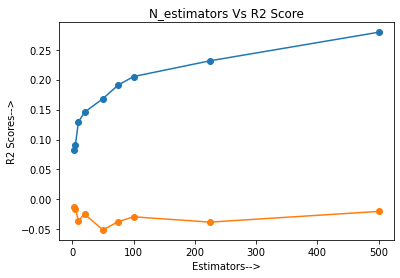

In [22]:
# Let's plot the train and CV score
plt.plot(n_estimators, train_scores,'o-',)
plt.plot(n_estimators, cv_scores,'o-')
plt.title("N_estimators Vs R2 Score")
plt.xlabel("Estimators-->")
plt.ylabel("R2 Scores-->")
plt.show()

- Here the custom model I developed is not working, it is giving the worst results than any other models I tried prreviously. So no point testing it on test data.